# TODO
- create `torch` modules ready to place at the top of the transformer
    - requires alignment with some interface of the autoencoder
- make the learning rate scheduler not vanish the lr rate
- add the schedulers of the loss terms to put attention to different terms throught training
- make the `Encoder` and `Decoder` modules flexible in terms of the dimensions (gradual bottlenecking)

In [2]:
import os

os.chdir("../src")

from utils import data_utils

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import Tensor
from typing import List, Tuple, Optional
from pandas import DataFrame
from argparse import Namespace
from sklearn.model_selection import train_test_split
import scanpy as sc
from utils import dev_notebooks_utils as dev
from utils.paths import LOGS_PATH
import h5py
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LinearLR, ExponentialLR, ChainedScheduler
from torch.utils.data import TensorDataset, DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
(train_tensor_data, val_tensor_data), (train_df, val_df), (train_raw, val_raw) = (
    dev.prepare_data_naive_mixing_version(
        val_frac=0.1,
        divide_by_nonzero_median=True,
        df_columns=["cell_type", "batch", "Site", "DonorNumber"],
        return_raw=True,
    )
)

/home/prz/bioml/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Subsampling anndata with fraction 1.0...


/home/prz/bioml/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [56]:
train_tensor_dataset = TensorDataset(train_tensor_data)
val_tensor_dataset = TensorDataset(val_tensor_data)

## Input PCA UMAP reference

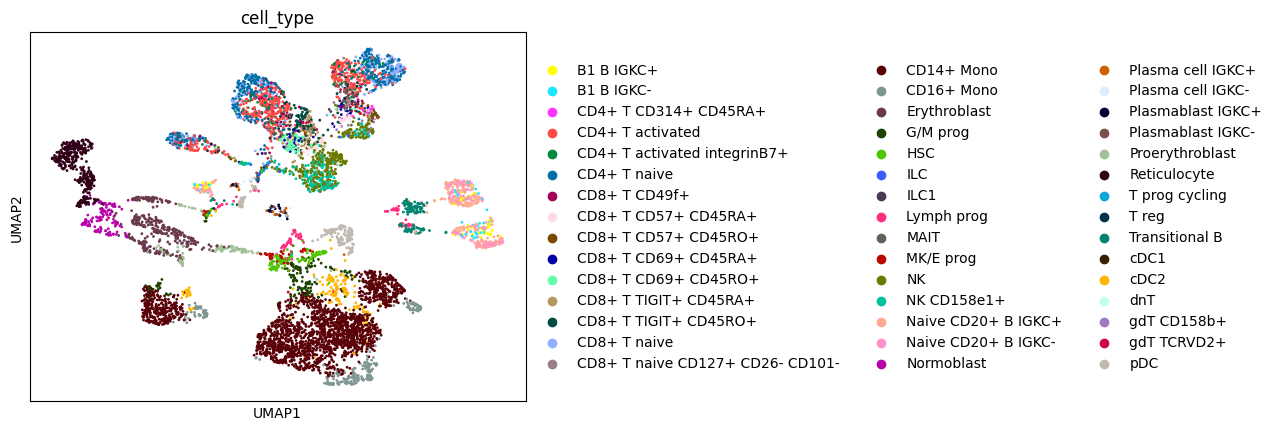

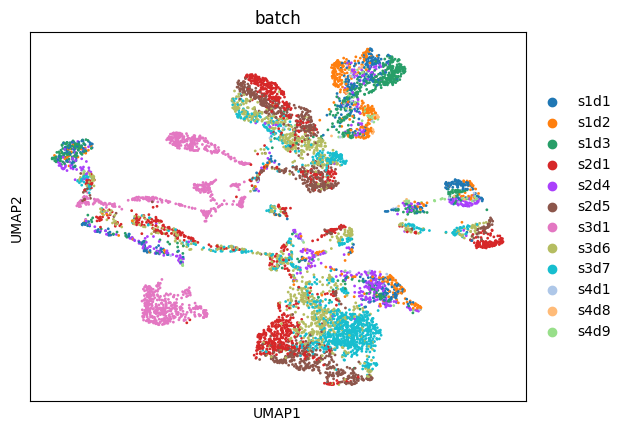

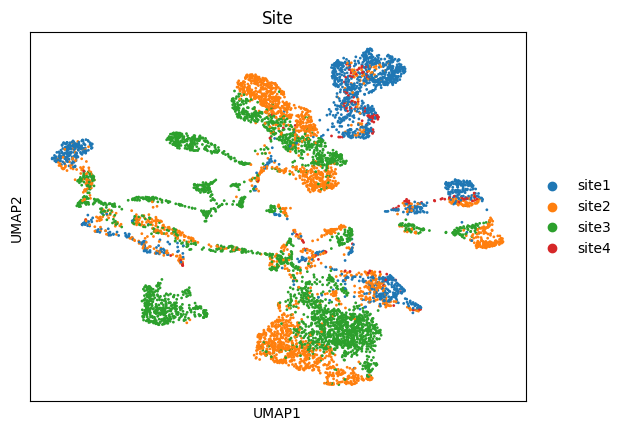

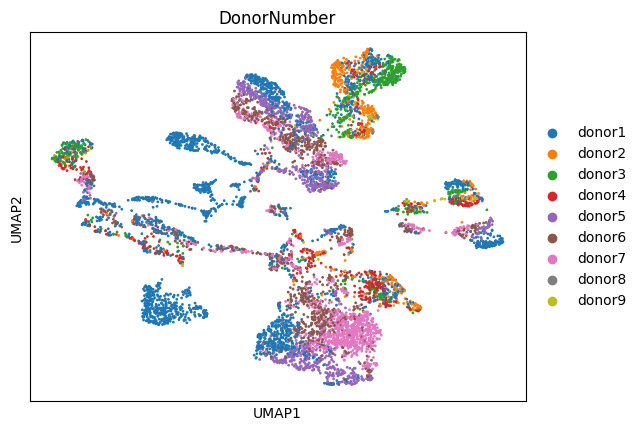

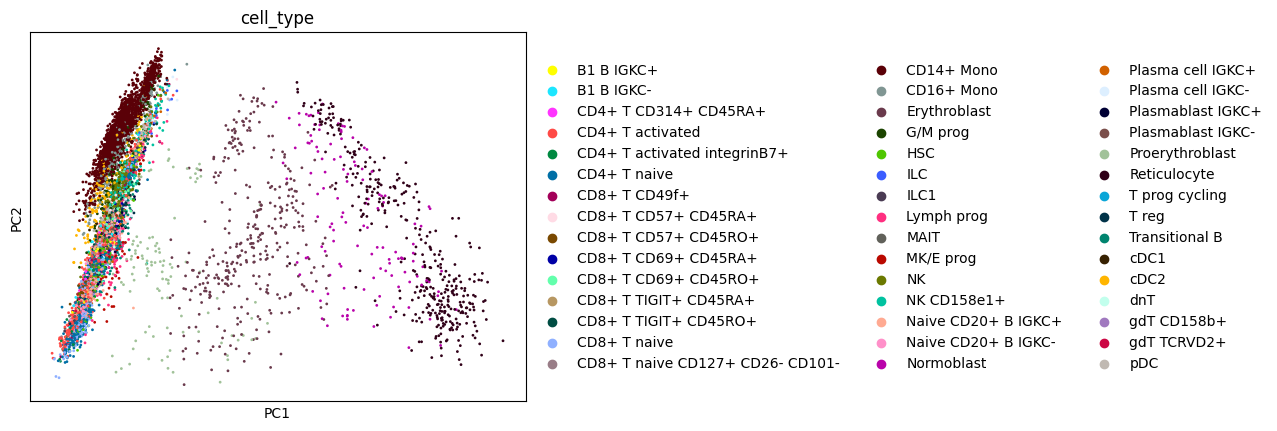

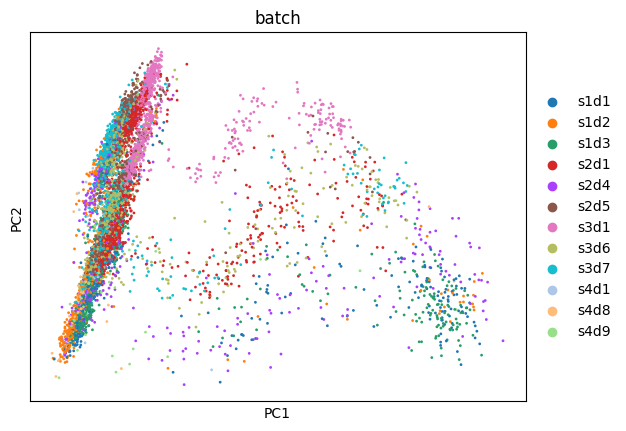

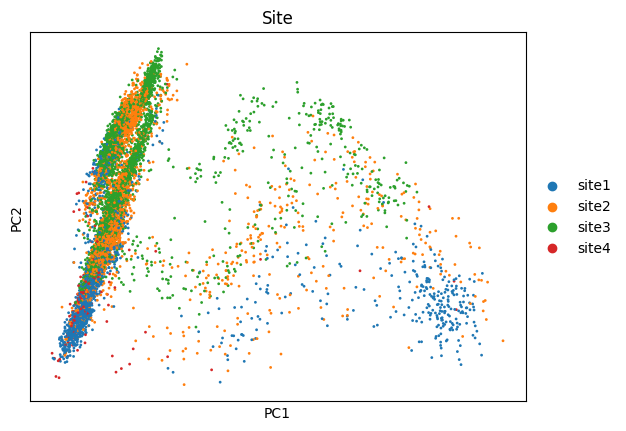

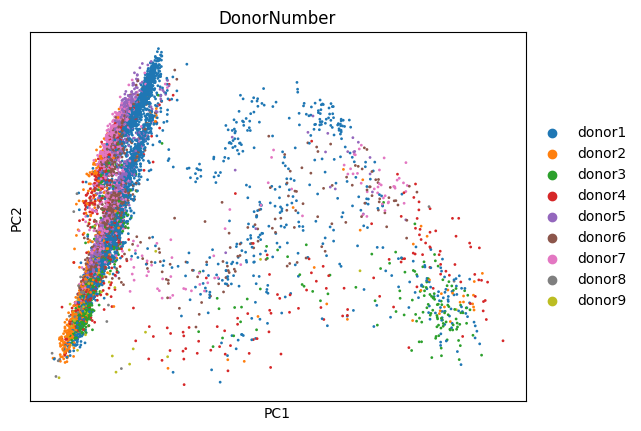

In [5]:
dev.draw_umaps_pca(val_tensor_data.numpy(), val_df)

#### Checking PCA after pearson residuals normalisation on the validation data

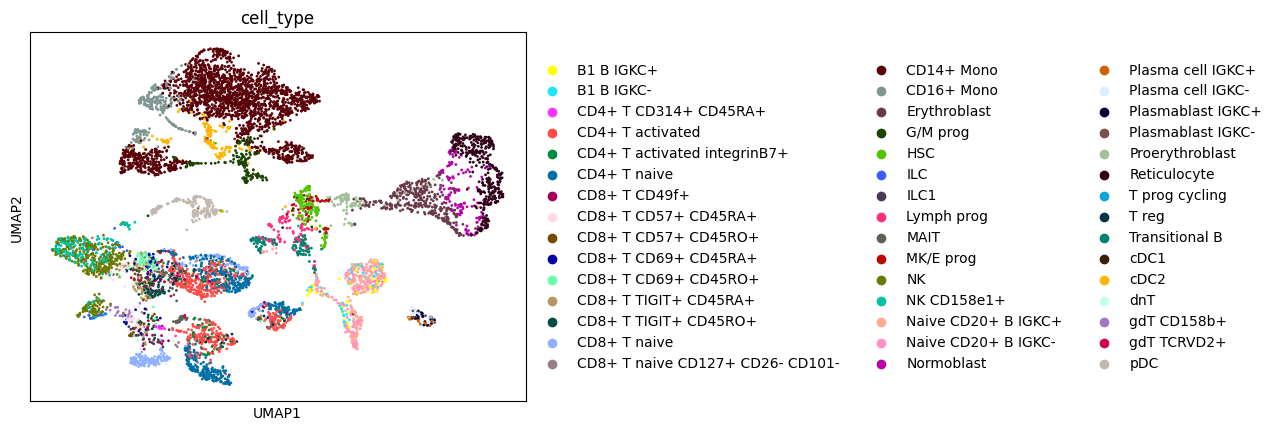

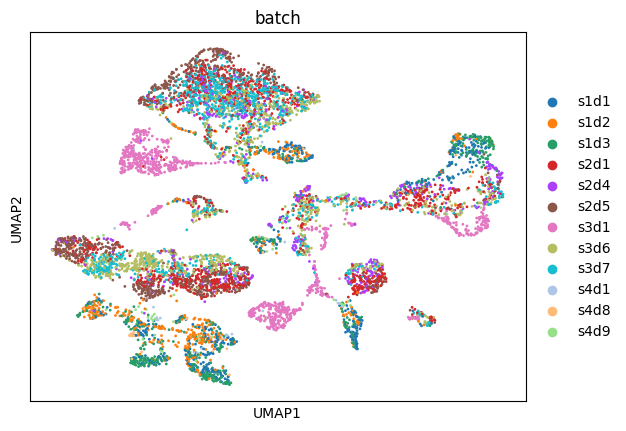

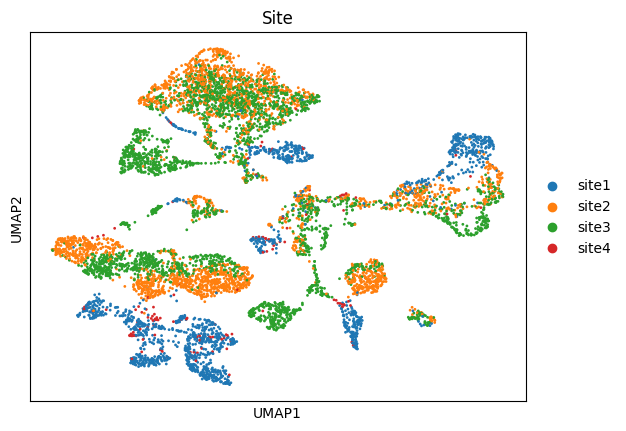

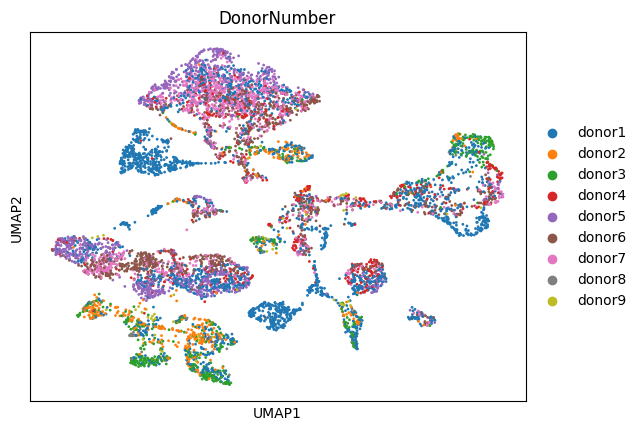

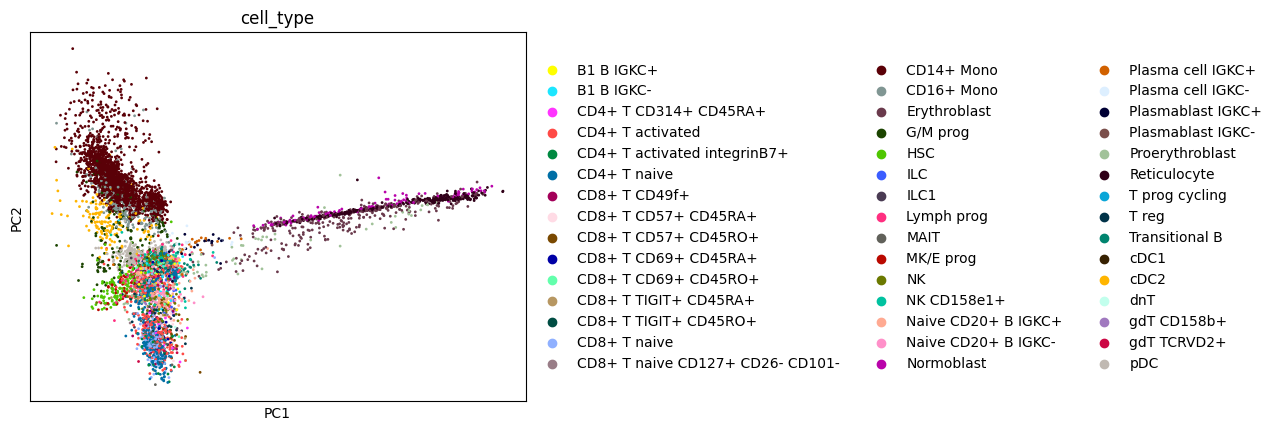

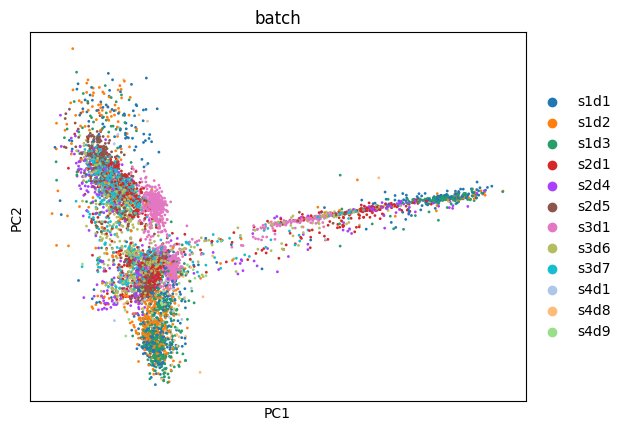

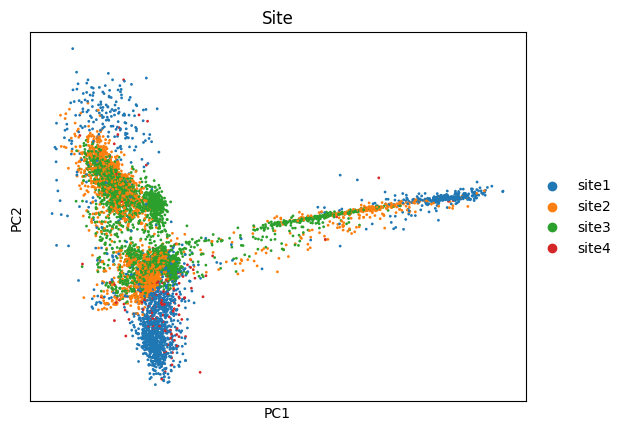

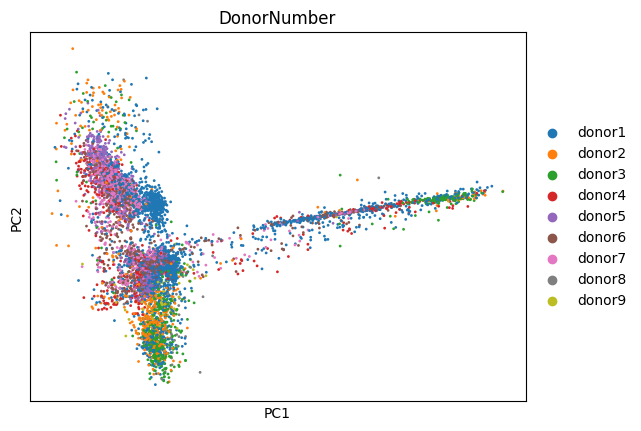

In [6]:
ad_tmp = ad.AnnData(X=val_raw.numpy(), obs=val_df)
sc.experimental.pp.normalize_pearson_residuals(ad_tmp)
dev.draw_umaps_pca(ad_tmp.X, val_df)
del ad_tmp

### Model components

In [8]:
class Encoder(nn.Module):
    def __init__(
        self,
        output_dims: int,
        hidden_dims: int,
        input_dims: int,
        dropout: float,
        batch_norm: bool,
    ):  # dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, latent_dims),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded


class Decoder(nn.Module):
    def __init__(
        self,
        input_dims: int,
        hidden_dims: int,
        decoded_dims: int,
        dropout: float,
        batch_norm: bool,
    ):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, decoded_dims),
        )

    def forward(self, z):
        decoded = self.decoder(z)
        return decoded

## AE

In [15]:
class AE(pl.LightningModule):
    def __init__(self, cfg):
        super(AE, self).__init__()
        self.encoder = Encoder(
            cfg.model.encoder.output_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.encoder.dropout,
            cfg.model.encoder.batch_norm,
        )
        self.decoder = Decoder(
            cfg.model.decoder.input_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.decoder.dropout,
            cfg.model.decoder.batch_norm,
        )
        self.cfg = cfg

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def configure_optimizers(self):
        encoder_optimizer_params = {
            "params": self.encoder.parameters(),
            **vars(self.cfg.training.optimizer.encoder),
        }
        decoder_optimizer_params = {
            "params": self.decoder.parameters(),
            **vars(self.cfg.training.optimizer.decoder),
        }
        optimizer = torch.optim.Adam(
            [encoder_optimizer_params, decoder_optimizer_params]
        )

        first_phase_scheduler = LinearLR(
            optimizer,
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.cfg.training.optimizer.first_phase_iters,
        )
        second_phase_scheduler = ExponentialLR(
            optimizer, gamma=self.cfg.training.optimizer.second_phase_gamma
        )
        scheduler = ChainedScheduler([first_phase_scheduler, second_phase_scheduler])

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": self.cfg.training.optimizer.scheduler_frequency,
            },
        }

In [40]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "ae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "encoder": {"batch_norm": True, "dropout": 0.1, "output_dim": 20},
        "decoder": {"batch_norm": True, "dropout": 0.1, "input_dim": 20},
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "n_epochs": 1,
    },
}

ae_cfg = dev.dict_to_namespace(cfg_dict)

In [55]:
train_loader = DataLoader(
    train_tensor_dataset, batch_size=ae_cfg.training.batch_size, shuffle=True
)
val_loader = DataLoader(
    val_tensor_dataset, batch_size=ae_cfg.training.batch_size, shuffle=False
)

NameError: name 'ae_cfg' is not defined

In [36]:
# run tensorboard
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 71729), started 0:32:35 ago. (Use '!kill 71729' to kill it.)

In [37]:
trainer = pl.Trainer(
    max_epochs=ae_cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=ae_cfg.model.model_name),
)
model = AE(ae_cfg)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 708 K  | train
1 | decoder | Decoder | 722 K  | train
--------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.722     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Embeddings UMAP - AE

In [14]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=model
)

In [15]:
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]

In [13]:
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

NameError: name 'embeddings' is not defined

## RAE
[From Variational to Deterministic Autoencoders](https://arxiv.org/abs/1903.12436)

### Components
#### Decoder regularisation
- implicit: dropout, batchnorm, noise during training
- explicit: higher weight decay, [instance noise](https://arxiv.org/pdf/1610.04490) in AE setup - just adding noise to the loss, does it even make any sense here? - i do not think so, weight clipping, gradient wrt latent penalty, spectral normalisation

In [96]:
from torch.nn.utils import spectral_norm


class RAE(AE):
    def __init__(self, cfg):
        super(RAE, self).__init__(cfg)
        if cfg.model.decoder.spectral_norm.is_applied:
            self._wrap_decoder_weights_with_spectral_norm()
        if cfg.model.decoder.weight_clipping.is_applied:
            self._clip_decoder_weights()

        if cfg.training.loss.latent_regularization.is_applied:
            if cfg.training.loss.latent_regularization.type == "l2":
                self._latent_reg_loss = lambda z: z.pow(2).sum()
            elif cfg.training.loss.latent_regularization.type == "huber":
                self._latent_reg_loss = lambda z: F.huber_loss(
                    z, torch.zeros_like(z), delta=1.0
                )

    def _wrap_decoder_weights_with_spectral_norm(self):
        r"""
        Apply spectral normalization to the decoder layers
        """
        for module in self.decoder.modules():
            if isinstance(
                module, nn.Linear
            ):  # note that it is applied to the linear layers only
                spectral_norm(
                    module,
                    n_power_iterations=self.cfg.model.decoder.spectral_norm.n_power_iterations,
                )  # This is implemented via a hook that calculates spectral norm and rescales weight before every forward() call.

    def _register_decoder_weight_clipping_hook(self):
        r"""
        Register a hook to clip the weights of the decoder
        """

        def _clip_weights_hook(module: nn.Module, input: Tensor) -> None:
            if module.training:
                if hasattr(module, "weight"):
                    with torch.no_grad():
                        module.weight.data._clamp(
                            self.cfg.model.decoder.weight_clipping.min,
                            self.cfg.model.decoder.weight_clipping.max,
                        )

        for module in self.decoder.modules():
            if isinstance(module, nn.Linear):
                module._register_forward_post_hook(_clip_weights_hook)

    # def _calc_decoder_output_gradient_wrt_input_sum_of_squares_loss_term(
    #     self, inputs: Tensor, outputs: Tensor
    # ) -> Tensor:
    #     r"""
    #     Compute the sum of squares of the gradient of the decoder output with respect to its latent input.
    #     """
    #     outputs_sum = outputs.sum()
    #     grads = torch.autograd.grad(
    #         outputs=outputs_sum,
    #         inputs=inputs,
    #         grad_outputs=torch.ones_like(outputs_sum),
    #     )[0]
    #     return grads.pow(2).sum()

    def _calc_latent_regularization_loss_term(self, z: Tensor) -> Tensor:
        r"""
        Compute the latent regularization loss
        """
        # return z.pow(2).sum()  # not putting 0.5 here as it is a constant factor
        return self._latent_reg_loss(z)

    def _calc_recon_loss_term(self, x_hat: Tensor, x: Tensor) -> Tensor:
        r"""
        Compute the reconstruction loss
        """
        return F.mse_loss(x_hat, x)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        # decoder_regularization_loss = (
        #     self._calc_decoder_output_gradient_wrt_input_sum_of_squares_loss_term(
        #         z, x_hat
        #     )
        # )
        loss = (
            self.cfg.training.loss.loss_weights.recon * recon_loss
            + self.cfg.training.loss.loss_weights.latent_regularization
            * latent_regularization_loss
            # + self.cfg.training.loss.loss_weights.decoder_regularization
            # * decoder_regularization_loss
        )
        self.log_dict(
            {
                "train_recon_loss": recon_loss,
                "train_latent_regularization_loss": latent_regularization_loss,
                # "train_decoder_regularization_loss": decoder_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        # decoder_regularization_loss = (
        #     self._calc_decoder_output_gradient_wrt_input_sum_of_squares_loss_term(
        #         z, x_hat
        #     )
        # )
        loss = (
            self.cfg.training.loss.loss_weights.recon * recon_loss
            + self.cfg.training.loss.loss_weights.latent_regularization
            * latent_regularization_loss
            # + self.cfg.training.loss.loss_weights.decoder_regularization
            # * decoder_regularization_loss
        )
        self.log_dict(
            {
                "val_recon_loss": recon_loss,
                "val_latent_regularization_loss": latent_regularization_loss,
                # "val_decoder_regularization_loss": decoder_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

In [108]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "rae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
            "spectral_norm": {
                "is_applied": True,
                "n_power_iterations": 1,
            },
            "weight_clipping": {
                "is_applied": False,
                "min": -1,
                "max": 1,
            },
        },
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
            "latent_regularization": {
                "is_applied": True,
                "type": "huber",
                "weight": 0.000001,
            },
            "decoder_regularization": {"is_applied": False, "weight": 1.0},
        },
        "n_epochs": 10,
    },
}

rae_cfg = dev.dict_to_namespace(cfg_dict)

In [109]:
model = RAE(rae_cfg)

In [110]:
trainer = pl.Trainer(
    max_epochs=rae_cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=rae_cfg.model.model_name),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [111]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 708 K  | train
1 | decoder | Decoder | 722 K  | train
--------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.722     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Embeddings UMAP - RAE

In [112]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=model
)

In [113]:
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]

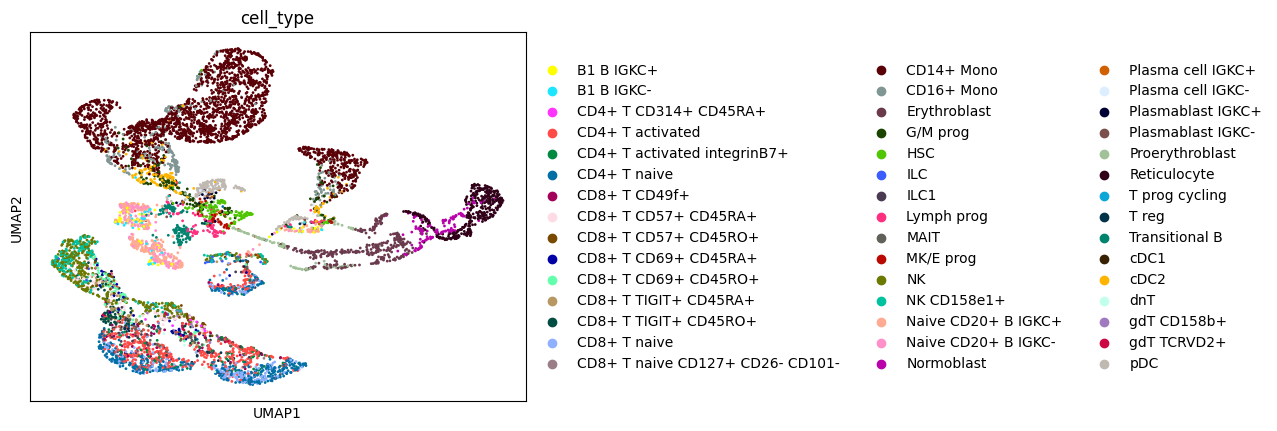

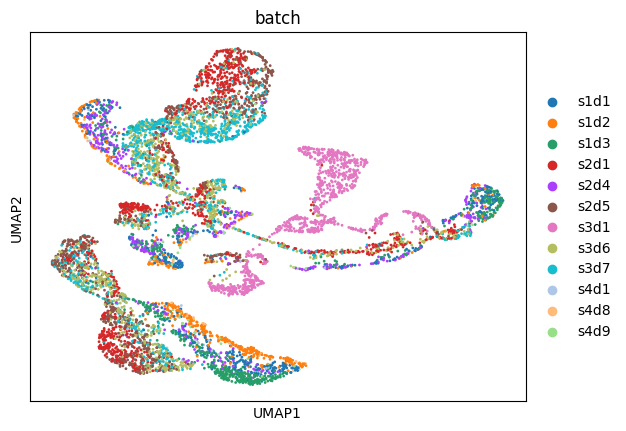

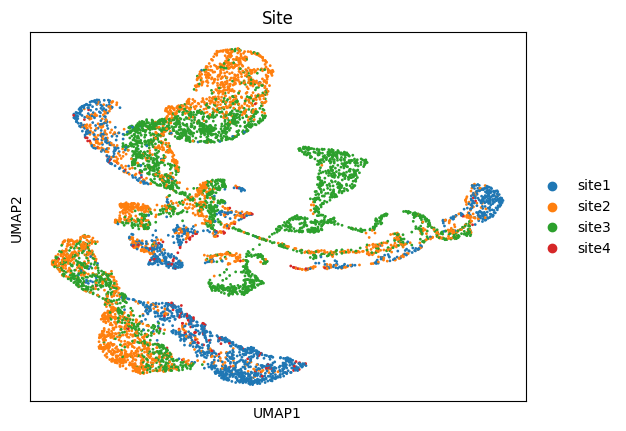

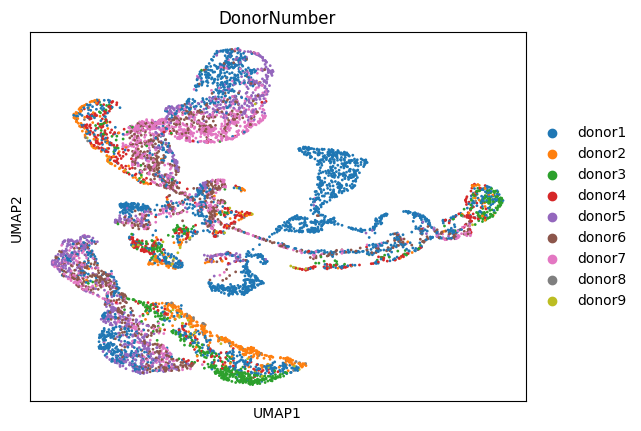

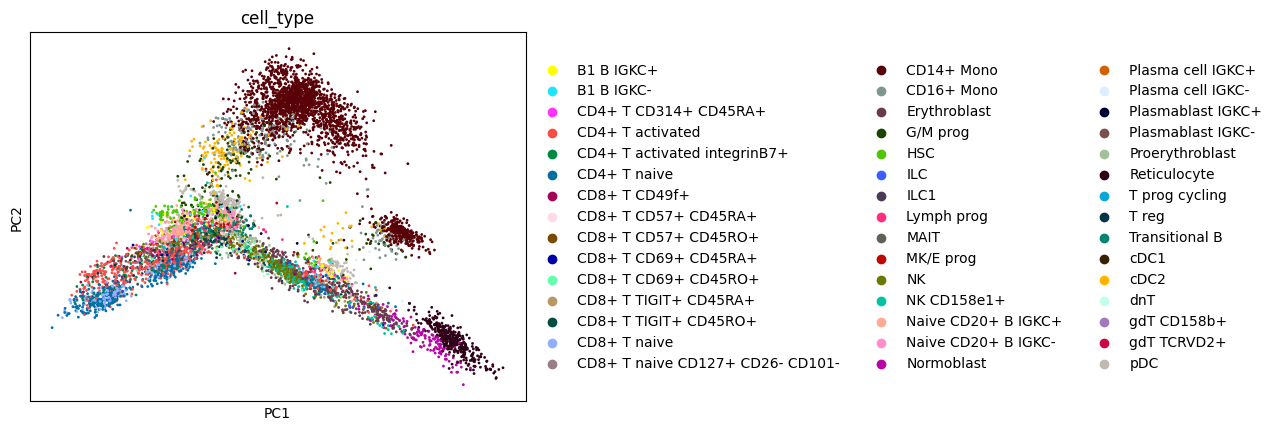

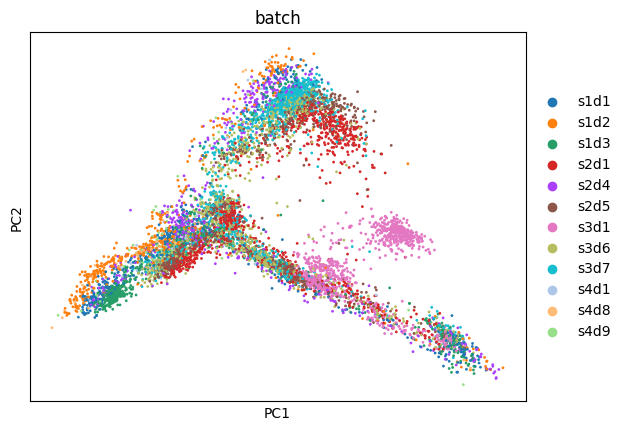

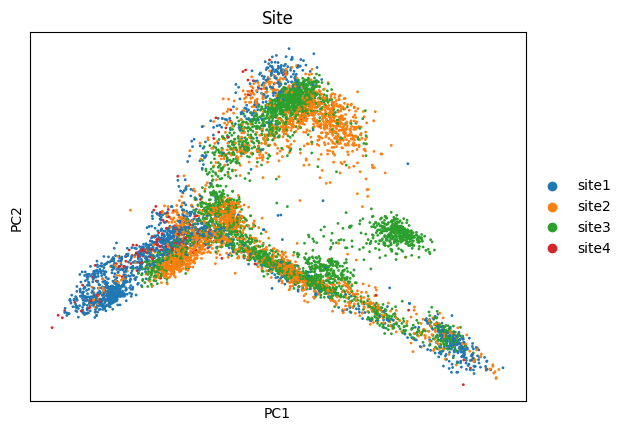

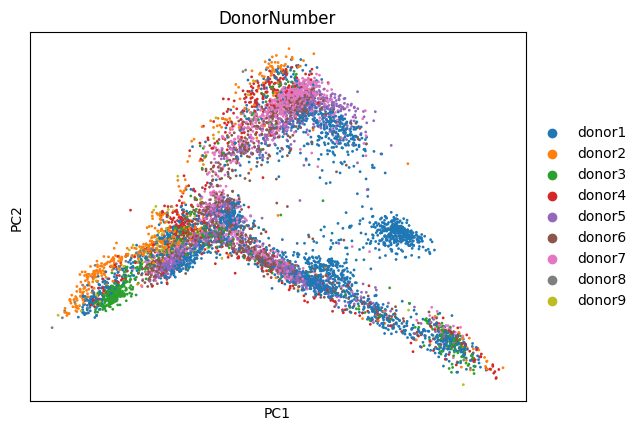

In [114]:
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

## FCRAE - RAE with latent fuzzy clustering

Latent constraint:

$-\log \sum_p \pi_p \cdot \exp(-d(z, \mu_p)) = -\log \sum_p \exp \log \left( \pi_p \cdot \exp(-d(z, \mu_p)) \right ) = -\log \sum_p \exp \left( \log \pi_p + \log \left(\exp(-d(z, \mu_p)) \right ) \right) = -\log \sum_p \exp \left( \log \pi_p -d(z, \mu_p)  \right) = -\log \text{sum} \exp_p \left( \log \pi_p -d(z, \mu_p)  \right)$

For specific distance metrics it may be treated like log likelihood of some mixture distribution.

Think through the possibility of all logits being driven up - is it encouraged? it does not seem so, but one must analyse the gradient. The gradient is softmax times the gradietn wrt the inside of softmax - the inside of softmax is always negative so all updates of the logits are positive  yajks

This is the same problem like in the policy gradient without bias.

Actually since the logits induced distribution is addition invariant the logits may be positive and if they grow too much they are punished as the logit minus stgh positive may be positive leading to negative gradient update, but the logit must be greater than the distance in the latent.

Actually actually it is the first case and it should blow up as for a logit we get softmax * 1 which gives always positive values...

## TODO add logits L1 penalty as translation does not change logsumexp in terms of relative values. Is there a better way to prevent the blow up without some clumbsy thresholds on the softmax values?

In [200]:
from torch.nn.utils import spectral_norm


class FCRAE(AE):
    def __init__(self, cfg):
        super(FCRAE, self).__init__(cfg)
        if cfg.model.decoder.spectral_norm.is_applied:
            self._wrap_decoder_weights_with_spectral_norm()
        if cfg.model.decoder.weight_clipping.is_applied:
            self._clip_decoder_weights()

        if cfg.training.losses.latent_regularization.is_applied:
            if cfg.training.losses.latent_regularization.type == "mse":
                self._latent_reg_loss = F.mse_loss
            elif cfg.training.losses.latent_regularization.type == "huber":
                self._latent_reg_loss = F.huber_loss
            else:
                raise NotImplementedError

        self.component_logits = torch.nn.Parameter(
            torch.zeros(cfg.model.latent_constraint.no_components)
        )
        self.component_means = torch.nn.Parameter(
            torch.empty(cfg.model.latent_constraint.no_components, cfg.model.latent_dim)
        )
        torch.nn.init.xavier_normal_(self.component_means)

    def _wrap_decoder_weights_with_spectral_norm(self):
        r"""
        Apply spectral normalization to the decoder layers
        """
        for module in self.decoder.modules():
            if isinstance(
                module, nn.Linear
            ):  # note that it is applied to the linear layers only
                spectral_norm(
                    module,
                    n_power_iterations=self.cfg.model.decoder.spectral_norm.n_power_iterations,
                )  # This is implemented via a hook that calculates spectral norm and rescales weight before every forward() call.

    def _register_decoder_weight_clipping_hook(self):
        r"""
        Register a hook to clip the weights of the decoder
        """

        def _clip_weights_hook(module: nn.Module, input: Tensor) -> None:
            if module.training:
                if hasattr(module, "weight"):
                    with torch.no_grad():
                        module.weight.data._clamp(
                            self.cfg.model.decoder.weight_clipping.min,
                            self.cfg.model.decoder.weight_clipping.max,
                        )

        for module in self.decoder.modules():
            if isinstance(module, nn.Linear):
                module._register_forward_post_hook(_clip_weights_hook)

    def _calc_latent_regularization_loss_term(self, z: Tensor) -> Tensor:
        r"""
        Compute the latent regularization loss.
        """
        return -torch.logsumexp(
            self.component_logits[None, :, None]
            - self._latent_reg_loss(
                z[:, None, :], self.component_means[None, :, :], reduction="none"
            ),
            dim=1,
        ).sum()

    def _calc_recon_loss_term(self, x_hat: Tensor, x: Tensor) -> Tensor:
        r"""
        Compute the reconstruction loss
        """
        return F.mse_loss(x_hat, x)

    def _calc_component_regularization_loss_term(self) -> Tensor:
        r"""
        Compute the component regularisation loss
        """
        return self.component_means.pow(2).sum()

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        component_regularization_loss = self._calc_component_regularization_loss_term()
        loss = (
            self.cfg.training.losses.recon.weight * recon_loss
            + self.cfg.training.losses.latent_regularization.weight
            * latent_regularization_loss
            + self.cfg.training.losses.latent_regularization.component_regularization.weight
            * component_regularization_loss
        )
        self.log_dict(
            {
                "train_recon_loss": recon_loss,
                "train_latent_regularization_loss": latent_regularization_loss,
                "train_component_regularization_loss": component_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        loss = (
            self.cfg.training.losses.recon.weight * recon_loss
            + self.cfg.training.losses.latent_regularization.weight
            * latent_regularization_loss
        )
        self.log_dict(
            {
                "val_recon_loss": recon_loss,
                "val_latent_regularization_loss": latent_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

In [201]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "fcrae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
            "spectral_norm": {
                "is_applied": True,
                "n_power_iterations": 1,
            },
            "weight_clipping": {
                "is_applied": False,
                "min": -1,
                "max": 1,
            },
        },
        "latent_constraint": {"no_components": 20},
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
            "latent_regularization": {
                "is_applied": True,
                "type": "mse",
                "weight": 0.1,
                "component_regularization": {
                    "is_applied": False,
                    "weight": 0.001,
                },
            },
            "decoder_regularization": {"is_applied": False, "weight": 1.0},
        },
        "n_epochs": 10,
    },
}

fcrae_cfg = dev.dict_to_namespace(cfg_dict)

In [202]:
model = FCRAE(fcrae_cfg)
trainer = pl.Trainer(
    max_epochs=fcrae_cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=fcrae_cfg.model.model_name),
)
trainer.fit(model, train_loader, val_loader)

## Embeddings UMAP - FCRAE

In [205]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=model
)
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

## CFCRAE - Conditional FCRAE

## WAE - Wasserstein AE - MMD

[Wasserstein Auto-Encoders](https://arxiv.org/abs/1711.01558)

[A Kernel Two-Sample Test](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html)

[kaggle mmd code reference](https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy)

O(batch_size^2) operations in the latent

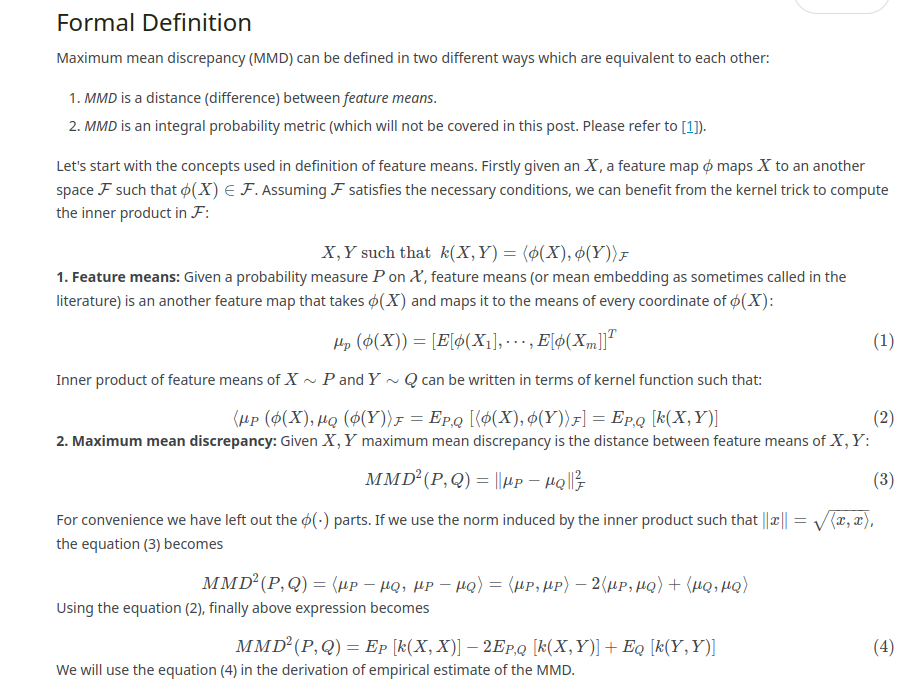
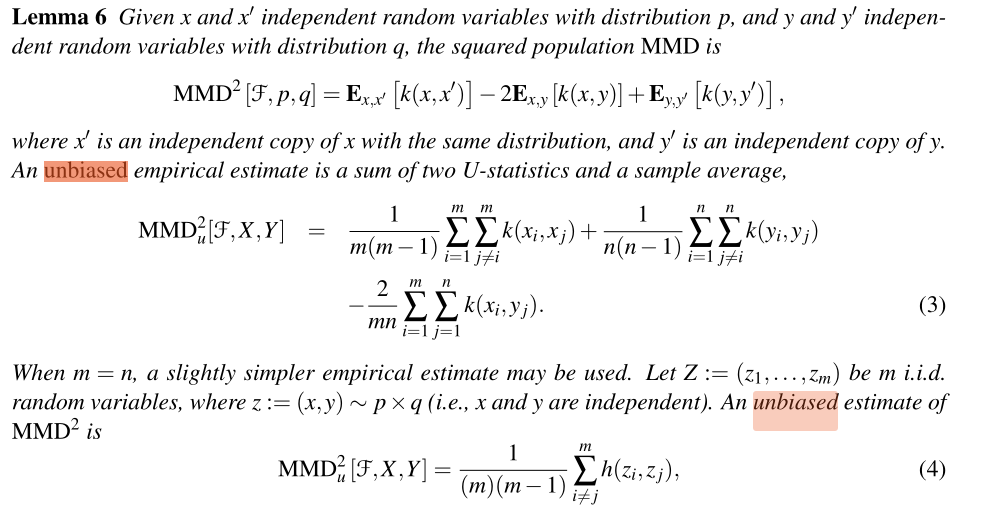
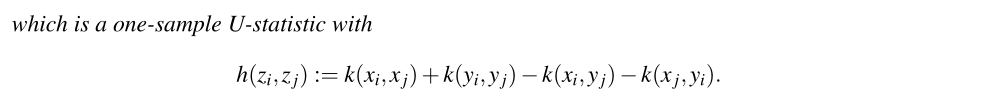

In [43]:
class WAE(AE):
    def __init__(self, cfg: Namespace):
        super(WAE, self).__init__(cfg)

    def _calc_mmd(self, x: Tensor, y: Tensor) -> Tensor:
        r"""
        Compute the Maximum Mean Discrepancy (MMD) between two samples
        """
        n = x.shape[0]
        m = y.shape[0]

        xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
        rx = xx.diag().unsqueeze(0)
        ry = yy.diag().unsqueeze(0)

        dxx = rx.t() + rx - 2.0 * xx
        dyy = ry.t() + ry - 2.0 * yy
        dxy = rx.t() + ry - 2.0 * zz

        # TODO: make the way of establishing a hyperparameter
        # C = torch.median(dxy) # idk weather this is the right way to calculate the median heuristic
        C = 2 * self.cfg.model.latent_dim * self.cfg.model.latent.components_std
        if self.cfg.model.mmd.kernel == "inverse_multiquadric":
            XX = C / (dxx + C).sum()
            YY = C / (dyy + C).sum()
            XY = C / (dxy + C).sum()
        elif self.cfg.model.mmd.kernel == "rbf":
            XX = torch.exp(-0.5 * dxx / C).sum()
            YY = torch.exp(-0.5 * dyy / C).sum()
            XY = torch.exp(-0.5 * dxy / C).sum()

        denominator_xx = (
            n * (n - 1) if n != 1 else 1
        )  # sthg has to be done if we have only one sample, it seeems we are biased then though
        denominator_yy = m * (m - 1) if m != 1 else 1  # same as above

        return XX / denominator_xx + YY / denominator_yy - 2.0 * XY / (n * m)

    def _sample_from_prior(self, n: int) -> Tensor:
        return (
            torch.randn(
                n, self.cfg.model.latent.no_components, self.cfg.model.latent_dim
            )
            * self.cfg.model.latent.components_std
        ).squeeze(
            1
        )  # for now considering just one component

    def _calc_recon_loss_term(self, x_hat: Tensor, x: Tensor) -> Tensor:
        r"""
        Compute the reconstruction loss
        """
        return F.mse_loss(x_hat, x)

    def _calc_mmd_loss_term(self, z: Tensor) -> Tensor:
        r"""
        Compute the Maximum Mean Discrepancy (MMD) loss
        """
        prior_sample = self._sample_from_prior(n=z.shape[0])
        return self._calc_mmd(z, prior_sample)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        encoded = self.encode(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        mmd_loss = self._calc_mmd_loss_term(z)
        loss = (
            self.cfg.training.losses.recon.weight * recon_loss
            + self.cfg.training.losses.mmd.weight * mmd_loss
        )
        self.log_dict(
            {"train_recon_loss": recon_loss, "train_mmd_loss": mmd_loss},
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        mmd_loss = self._calc_mmd_loss_term(z)
        loss = (
            self.cfg.training.losses.recon.weight * recon_loss
            + self.cfg.training.losses.mmd.weight * mmd_loss
        )
        self.log_dict(
            {"val_recon_loss": recon_loss, "val_mmd_loss": mmd_loss},
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

In [68]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "wae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {"batch_norm": True, "dropout": 0.0},
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "latent": {"deterministic": True, "no_components": 1, "components_std": 1.0},
        "mmd": {
            "kernel": "inverse_multiquadric",
        },
    },
    "training": {
        "n_epochs": 10,
        "batch_size": 128,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
            "mmd": {"weight": 10000},
        },
    },
}

wae_cfg = dev.dict_to_namespace(cfg_dict)

In [69]:
def test_mmd(cfg: Namespace):
    wae = WAE(cfg)
    x = torch.randn(4, 10)
    y = torch.randn(6, 10)
    print(wae._calc_mmd(x, y))


test_mmd(wae_cfg)

tensor(0.0022)


In [70]:
from typing import Type, Any


def build_and_fit_model(
    constructor: Type[Any],
    cfg: Namespace,
    train_tensor_data: Tensor,
    val_tensor_data: Tensor,
) -> Any:
    train_tensor_dataset = TensorDataset(train_tensor_data)
    train_loader = DataLoader(
        train_tensor_dataset, batch_size=cfg.training.batch_size, shuffle=True
    )
    val_tensor_dataset = TensorDataset(val_tensor_data)
    val_loader = DataLoader(
        val_tensor_dataset, batch_size=cfg.training.batch_size, shuffle=False
    )
    model = constructor(cfg)
    trainer = pl.Trainer(
        max_epochs=cfg.training.n_epochs,
        logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=cfg.model.model_name),
    )
    trainer.fit(model, train_loader, val_loader)
    return model

In [71]:
fitted_model = build_and_fit_model(WAE, wae_cfg, train_tensor_data, val_tensor_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 708 K  | train
1 | decoder | Decoder | 722 K  | train
--------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.722     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


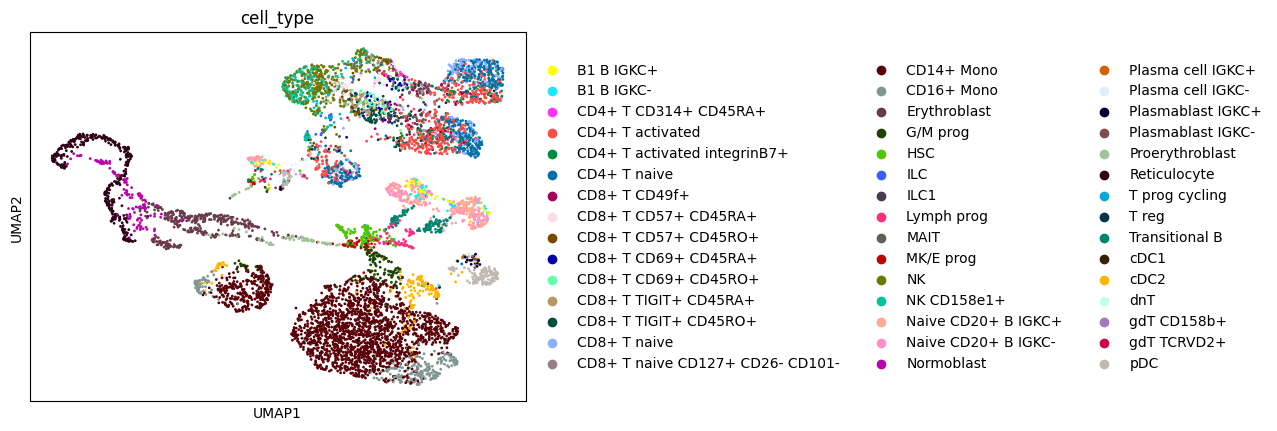

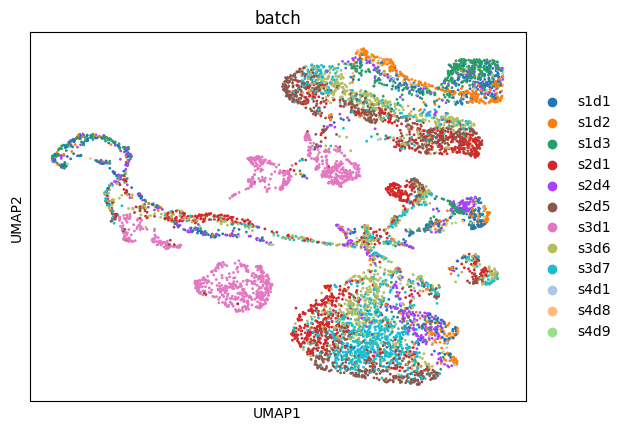

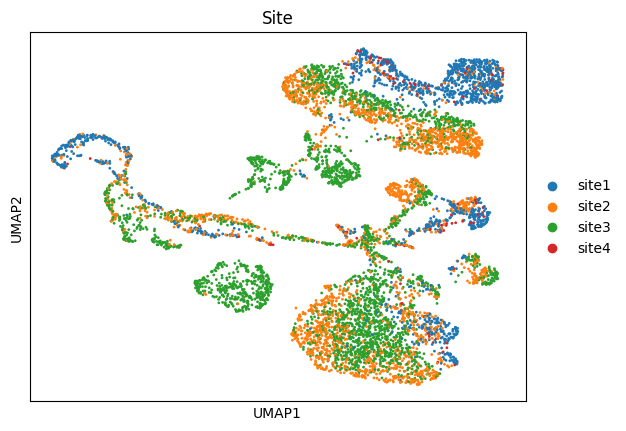

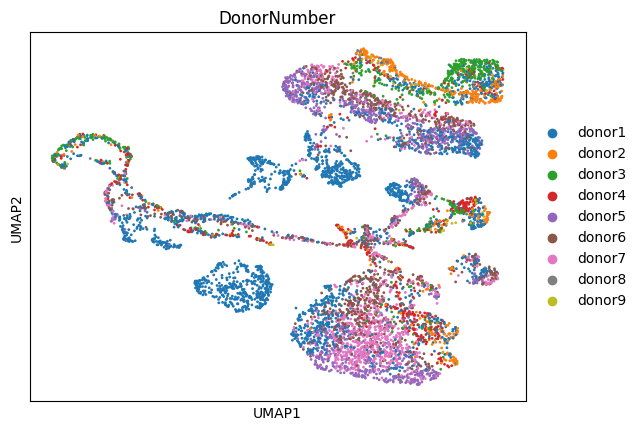

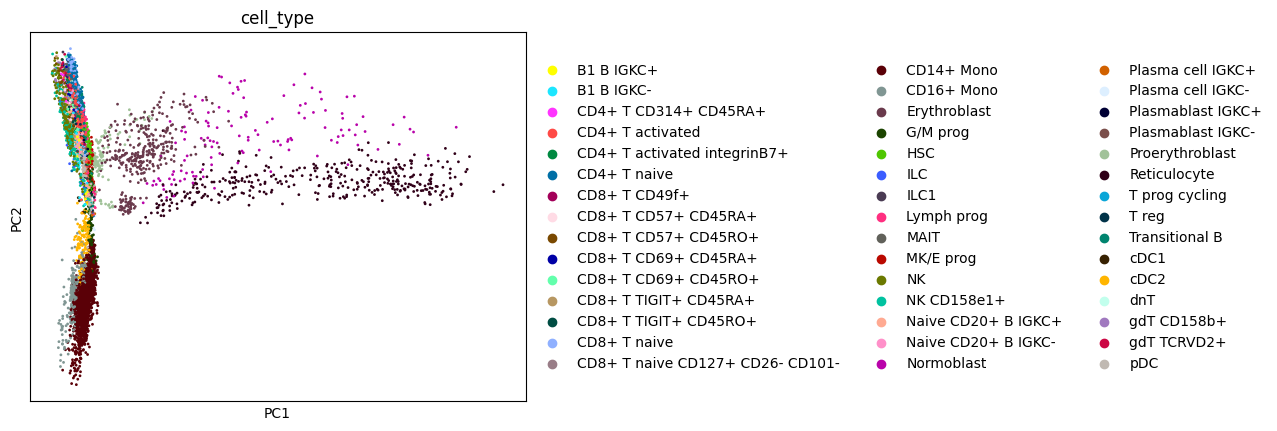

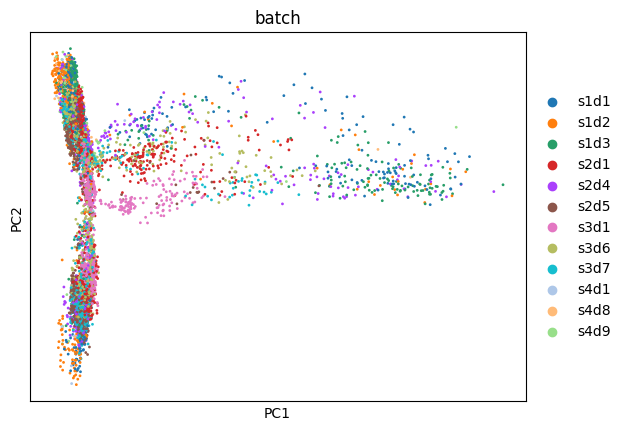

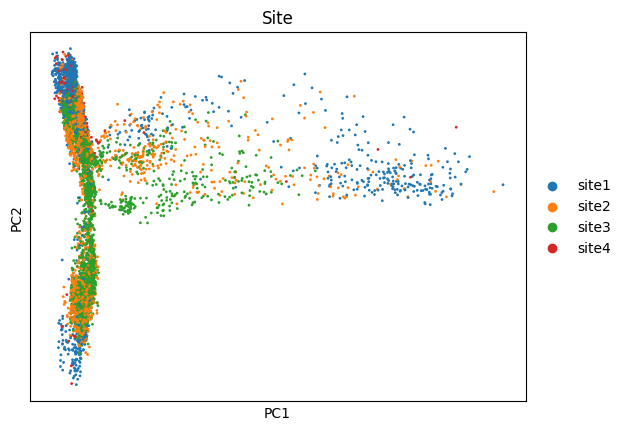

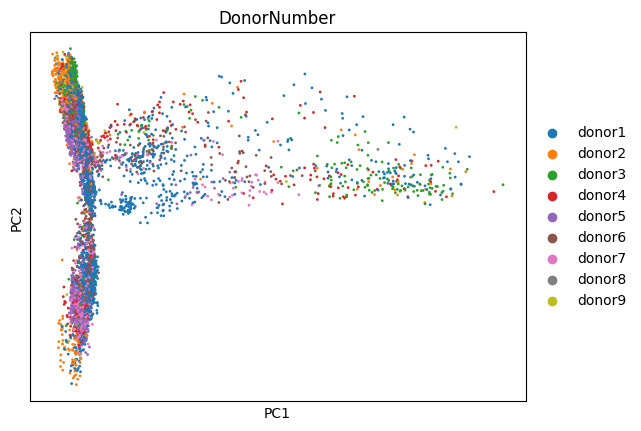

In [72]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=fitted_model
)
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

## Info VAE

In [ ]:
class InfoVAE(WAE):
    def __init(self, cfg: Namespace):
        super(InfoVAE).__init__(cfg)

In [ ]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "wae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim2x": 40,  # induces encoder output dim and decoder input dim
        "encoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "latent": {"no_components": 1, "components_std": 1.0},
        "mmd": {
            "kernel": "inverse_multiquadric",
        },
    },
    "training": {
        "n_epochs": 10,
        "batch_size": 128,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
            "mmd": {"weight": 10000},
        },
    },
}

wae_cfg = dev.dict_to_namespace(cfg_dict)

## AAE - special case of WAE
described in WAE paper
[Adversarial Autoencoders](https://arxiv.org/abs/1511.05644)

## AVB - matches posterior not posterior marginal
described in WAE paper
[Adversarial Variational Bayes: Unifying Variational Autoencoders and Generative Adversarial Networks](https://arxiv.org/abs/1701.04722)


## Probabilistic encoder WAE

## CWAE - Conditional Wasserstein AE

Conditional GM prior with semi supervised option.

Dataloader with conditioning labels.

The issue here is that we have to sample corresponding samples for each prior compnent with different number of samples in each. At some point it seems to require for loop over components.

In [49]:
def create_dataloader_with_conditioning(
    tensor_data: Tensor,
    df: DataFrame,
    batch_size: int,
    shuffle: bool,
    condition_column: str,
    drop_prob: float = 0.0,
) -> DataLoader:
    cond = torch.tensor(df[condition_column].cat.codes.values, dtype=torch.long)
    mask = torch.bernoulli(torch.full(cond.size(), drop_prob)).bool()
    cond[mask] = len(
        train_df["cell_type"].cat.categories
    )  # the last condition is the "unknown" condition
    tensor_dataset = TensorDataset(tensor_data, cond)
    return DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)

In [38]:
train_loader = create_dataloader_with_conditioning(
    train_tensor_data,
    train_df,
    64,
    True,
    "cell_type",
    0.01,  # the drop prob is use to simulate lacking labels for a subset of the data
)
val_loader = create_dataloader_with_conditioning(
    val_tensor_data, val_df, 64, False, "cell_type", 0.01
)

In [57]:
import torch.distributions as td

categorical = td.Categorical(logits=torch.ones(3))
comp = td.Independent(
    td.Normal(torch.randn((3, 2)), torch.ones((3, 2))), reinterpreted_batch_ndims=1
)
gm = td.MixtureSameFamily(categorical, comp)

In [69]:
import torch

# Example tensor of type torch.long
tensor = torch.tensor([1, 3, 2, 3, 3, 4, 4, 7], dtype=torch.long)

# Flatten the tensor if it's not already 1D (optional, depending on your tensor)
tensor_flat = tensor.view(-1)

# Count occurrences of each value
counts = torch.bincount(tensor_flat, minlength=10)

print(counts)
torch.nonzero(counts).flatten()

tensor([0, 1, 1, 3, 2, 0, 0, 1, 0, 0])


tensor([1, 2, 3, 4, 7])

In [ ]:
import torch.distributions as td


class OmiGMPriorProbabilisticAE(pl.LightningModule):
    def __init__(self, cfg: Namespace):
        super(OmiGMPriorProbabilisticAE, self).__init__()
        self.cfg = cfg
        self.encoder = Encoder(
            cfg.model.latent_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.encoder.dropout,
            cfg.model.encoder.batch_norm,
        )
        self.decoder = Decoder(
            cfg.model.latent_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.decoder.dropout,
            cfg.model.decoder.batch_norm,
        )
        self.component_logits = nn.Parameter(
            data=torch.zeros(size=(cfg.no_components,)), requires_grad=True
        )
        self.component_means = nn.Parameter(
            torch.randn(cfg.no_components, cfg.latent_dim), requires_grad=True
        )
        self.register_buffer(
            "component_stds",
            torch.full((cfg.no_components, cfg.latent_dim), cfg.components_std),
        )
        self.cfg = cfg

    def training_step(self, batch: Tuple[Tensor]):
        x, cond = batch[0]
        batch_size = x.shape[0]

        encoded = self.encoder(x)
        cond_counts = torch.bincount(cond)
        nonzero_cond_counts = torch.nonzero(cond_counts).flatten()
        unknown_cond_mask = (
            cond == self.cfg.model.latent.no_components
        )  # the last condition is the "unknown" condition, conditions 0 - no_components-1 are the known conditions

        gmm = self._make_gmm()
        per_component_log_prob = (
            -gmm.component_distribution.log_prob(  # log_prob into negative log_prob
                z_sample
            )
        )  # (no_laten_samples, batch_size, no_components)
        # assert per_component_log_prob.shape == (
        #     self.cfg.no_latent_samples,
        #     batch_size,
        #     self.cfg.no_components,
        # ), AssertionError(
        #     f"per_component_logprob shape is {per_component_log_prob.shape}, expected {(self.cfg.no_latent_samples, batch_size, self.cfg.no_components)}"
        # )
        component_indicator = torch.arange(self.cfg.no_components).unsqueeze(0).repeat(
            (batch_size, 1)
        ) == labels.unsqueeze(1)
        # assert component_indicator.shape == (
        #     batch_size,
        #     self.cfg.no_components,
        # ), AssertionError(
        #     f"component_indicator shape is {component_indicator.shape}, expected {(batch_size, self.cfg.no_components)}"
        # )
        gmm_likelihood_per_k = per_component_log_prob[
            :, component_indicator
        ]  # (no_laten_samples, batch_size)
        # assert gmm_likelihood_per_k.shape == (
        #     self.cfg.no_latent_samples,
        #     batch_size,
        # ), AssertionError(
        #     f"gmm_likelihood_per_k shape is {gmm_likelihood_per_k.shape}, expected {(self.cfg.no_latent_samples, batch_size)}"
        # )
        z_to_decode = z_sample.squeeze(2).reshape(
            -1, self.cfg.latent_dim
        )  # (self.cfg.no_latent_samples * batch_size, self.cfg.latent_dim)
        # print("z_to_decode", z_to_decode.shape)
        x_hat = self.decoder(z_to_decode).reshape(
            self.cfg.no_latent_samples, batch_size, -1
        )  # (self.cfg.no_latent_samples, batch_size, sum_of_modalities)
        # print("x_hat", x_hat.shape, x.repeat(self.cfg.no_latent_samples, 1, 1).shape)
        # assert x_hat.shape == x.repeat(self.cfg.no_latent_samples, 1, 1).shape
        recon_loss_per_k = F.mse_loss(
            x_hat, x.repeat(self.cfg.no_latent_samples, 1, 1), reduction="none"
        ).mean(
            dim=-1
        )  # (no_laten_samples, batch_size)
        # assert recon_loss_per_k.shape == (
        #     self.cfg.no_latent_samples,
        #     batch_size,
        # ), AssertionError(
        #     f"recon_loss_per_k shape is {recon_loss_per_k.shape}, expected {(self.cfg.no_latent_samples, batch_size)}"
        # )
        if self.cfg.no_latent_samples > 1:  # IWAE with multiple samples
            total_loss = torch.logsumexp(
                self.cfg.gmm_likelihood_loss_coef * gmm_likelihood_per_k
                - self.cfg.entropy_loss_coef * entropy_per_batch_sample
                + self.cfg.recon_loss_coef * recon_loss_per_k,
                dim=0,
            ).mean()
        else:  # IWAE reduces to VAE with single sample
            total_loss = (
                self.cfg.gmm_likelihood_loss_coef * gmm_likelihood_per_k
                - self.cfg.entropy_loss_coef * entropy_per_batch_sample
                + self.cfg.recon_loss_coef * recon_loss_per_k
            ).mean()
        self.log("Train loss", total_loss, on_epoch=True, prog_bar=True)
        self.log(
            "Reconstruction loss", recon_loss_per_k.mean(), on_epoch=True, prog_bar=True
        )
        self.log(
            "GMM likelihood loss",
            self.cfg.gmm_likelihood_loss_coef * gmm_likelihood_per_k.mean(),
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "Entropy loss",
            -self.cfg.entropy_loss_coef * entropy_per_batch_sample.mean(),
            on_epoch=True,
            prog_bar=True,
        )

        return total_loss

    def predict_step(self, batch: Tensor) -> Tensor:
        # print("gmm omiwae predict step...")
        x1, x2 = batch
        x = torch.cat((x1, x2), dim=-1)
        z_means, _ = self.encoder(x).chunk(2, dim=-1)
        return z_means

    def _var_transformation(self, std: Tensor) -> Tensor:
        return F.softplus(std) + 1e-6

    def _make_normal_rv(self, mu: Tensor, var: Tensor):
        return td.Normal(mu, var)

    def _make_gmm(self):
        categorical = td.Categorical(logits=self.component_logits)
        comp = td.Independent(
            td.Normal(self.means, self.stds), reinterpreted_batch_ndims=1
        )
        return td.MixtureSameFamily(categorical, comp)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.cfg.lr)
        return optimizer

In [ ]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "wae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "latent": {"no_components": 20, "components_std": 1.0},
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
        },
        "decoder_regularization": {"is_applied": False, "weight": 1.0},
    },
    "n_epochs": 10,
}

wae_cfg = dev.dict_to_namespace(cfg_dict)

## HVM

## Hierarchical VampPrior VAE

## Batch disentangled model

here the architecture should be described

## Improved IWAE?

## WAE - Wasserstein AE
and full covariance matrix instead of just standard deviations

## Hierarchy - constrained by mean of mixture means